[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1AoolDYePUpPkRCKIu0cP9zV7lX5QGD3Z?usp=sharing)

In [1]:
# !pip install rudalle==0.0.1rc8 > /dev/null

In [5]:
import pandas as pd
import os
import ast
from tqdm import tqdm
tqdm.pandas()

In [6]:
ALLOWED_MEMORY = 7 # choose your GPU memory in GB  
if ALLOWED_MEMORY < 4.5:
    DALLE_BS = 1
elif ALLOWED_MEMORY < 5.5:
    DALLE_BS = 2
elif ALLOWED_MEMORY < 6.5:
    DALLE_BS = 3
elif ALLOWED_MEMORY < 7.5:
    DALLE_BS = 4
elif ALLOWED_MEMORY < 8.5:
    DALLE_BS = 5
elif ALLOWED_MEMORY < 9.5:
    DALLE_BS = 6
elif ALLOWED_MEMORY < 10.5:
    DALLE_BS = 7
else:
    DALLE_BS = 8
    
print('ruDALL-E batch size:', DALLE_BS)

ruDALL-E batch size: 4


In [7]:
import multiprocessing
import torch
from psutil import virtual_memory


ram_gb = round(virtual_memory().total / 1024**3, 1)
print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

!nvidia-smi

CPU: 20
RAM GB: 15.6
PyTorch version: 2.2.1
CUDA version: 11.8
cuDNN version: 8700
Thu Mar 21 17:28:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0             13W /  105W |       0MiB /   8188MiB |      0%      Default |
|                                         |              

In [8]:
import transformers
import more_itertools
from tqdm.auto import tqdm

from rudalle.pipelines import show, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_ruclip
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True)

# prepare utils:
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')

c:\Users\aravi\miniconda3\envs\idl-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\aravi\miniconda3\envs\idl-project\lib\site-packages\huggingface_hub\file_download.py:678: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
ruclip --> ready


In [9]:
def generate_codebooks(text, tokenizer, dalle, top_k, top_p, images_num, image_prompts=None, temperature=1.0, bs=8,
                    seed=None, use_cache=True):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    codebooks = []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            has_cache = False
            if image_prompts is not None:
                prompts_idx, prompts = image_prompts.image_prompts_idx, image_prompts.image_prompts
                prompts = prompts.repeat(chunk_bs, 1)
            for idx in tqdm(range(out.shape[1], total_seq_length)):
                idx -= text_seq_length
                if image_prompts is not None and idx in prompts_idx:
                    out = torch.cat((out, prompts[:, idx].unsqueeze(1)), dim=-1)
                else:
                    logits, has_cache = dalle(out, attention_mask,
                                              has_cache=has_cache, use_cache=use_cache, return_loss=False)
                    logits = logits[:, -1, vocab_size:]
                    logits /= temperature
                    filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                    probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                    sample = torch.multinomial(probs, 1)
                    out = torch.cat((out, sample), dim=-1)
            codebooks.append(out[:, -image_seq_length:].cpu())
    return codebooks

In [10]:
text = 'Орел сидит на дереве и смотрит в сторону'

seed_everything(9)
codebooks = []
for top_k, top_p, images_num in [
    (2048, 0.995, 1),
#     (1536, 0.99, 8),
#     (1024, 0.99, 8),
#     (1024, 0.98, 8),
#     (512, 0.97, 8),
#     (384, 0.96, 8),
    # (256, 0.95, 8),
    # (128, 0.95, 8),
]:
    codebooks += generate_codebooks(text, tokenizer, dalle,
                                    top_k=top_k, images_num=images_num,
                                    top_p=top_p, bs=DALLE_BS,
                                    use_cache=False)

pil_images = []
for _codebooks in tqdm(torch.cat(codebooks).cpu()):
    with torch.no_grad():
        images = vae.decode(_codebooks.unsqueeze(0))
        pil_images += torch_tensors_to_pil_list(images)

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


c:\Users\aravi\miniconda3\envs\idl-project\lib\site-packages\rudalle\pipelines.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fix.show()


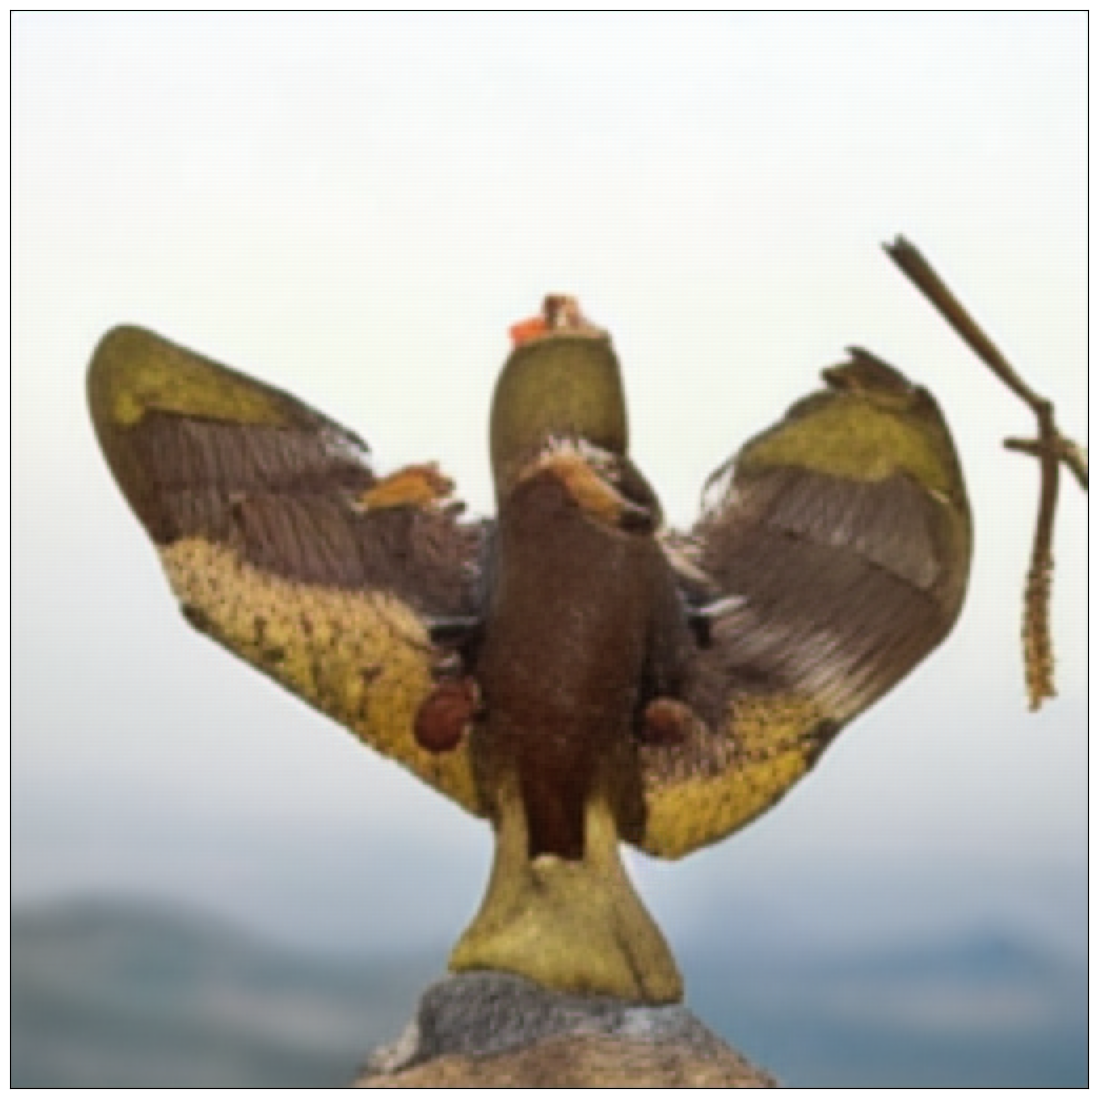

In [11]:
show(pil_images, 4)

c:\Users\aravi\miniconda3\envs\idl-project\lib\site-packages\rudalle\pipelines.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fix.show()


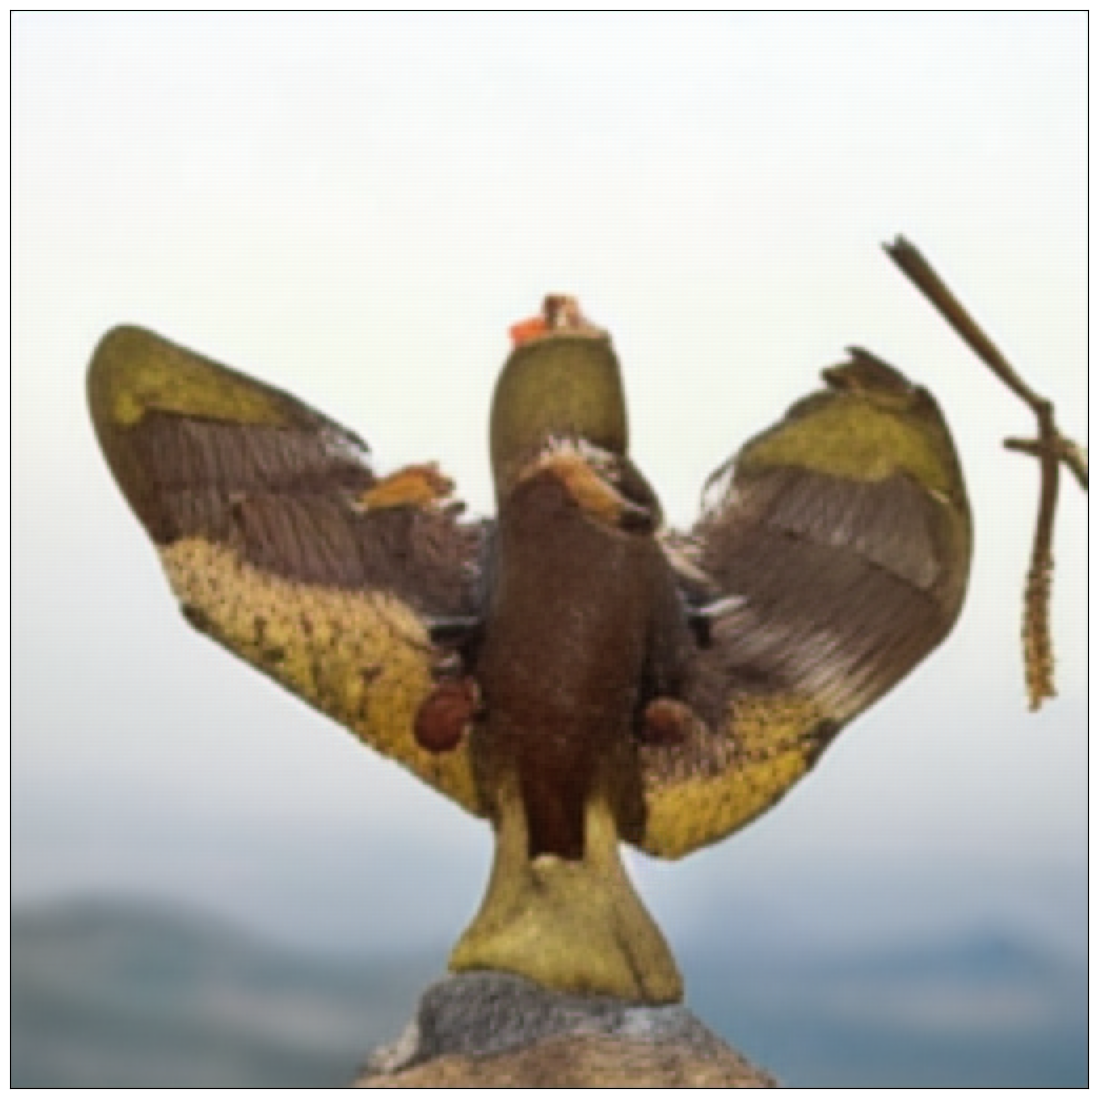

In [12]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device='cpu', count=6)
show(top_images, 3)

In [16]:
# def cleanup_path(file_name):
#     return os.path.join(data_dir, "val2017", file_name)

# def get_first_caption(captions_list):
#     captions_list = ast.literal_eval(captions_list)
#     return captions_list[0]

data_dir = "data"
# animals_df = pd.read_csv(os.path.join(data_dir, "animals.csv"))
# animals_df["file_path"] = animals_df["file_name"].apply(cleanup_path)
# animals_df["single_caption"] = animals_df["caption"].apply(get_first_caption)
# animals_df = animals_df.iloc[:100, :]

In [19]:
pil_images
from PIL import Image


In [2]:
# from google.cloud import translate_v2 as translate

# translate_client = translate.Client()

# def translate_text(text, target='ru'):
#     result = translate_client.translate(text, target_language=target)
#     return result['translatedText']

# animals_df["single_caption_russian"] = animals_df["single_caption"].progress_apply(translate_text)
# animals_df.to_csv(os.path.join(data_dir, "animals_top_100.csv"), index=False)

In [11]:
# animals_df = pd.read_csv(os.path.join(data_dir, "animals_top_100.csv"))

('Коричневая собака высунула голову из окна машины.',
 "A brown dog hanging it's head out of a car window.")

In [3]:
prompts = [
"A red apple",
"A blue sky with white clouds",
"A yellow sunflower",
"A green tree",
"A black cat",
"A white snowman",
"A brown horse",
"A pink pig",
"A gray elephant",
"A purple butterfly",
"A silver car",
"A golden crown",
"A blue ocean",
"A red rose",
"A green frog",
"A yellow duck",
"A black spider",
"A white rabbit",
"A brown bear",
"A pink flamingo",
"A gray wolf",
"A purple grape",
"A silver moon",
"A golden sun",
"A blue bird",
"A red heart",
"A green leaf",
"A yellow banana",
"A black piano",
"A white cloud",
"A brown monkey",
"A pink tulip",
]
prompts_in_russian = [
"Красное яблоко",
"Голубое небо с белыми облаками",
"Желтый подсолнух",
"Зеленое дерево",
"Черная кошка",
"Белый снеговик",
"Коричневая лошадь",
"Розовая свинья",
"Серый слон",
"Фиолетовая бабочка",
"Серебряная машина",
"Золотая корона",
"Синий океан",
"Красная роза",
"Зеленая лягушка",
"Желтая утка",
"Черный паук",
"Белый кролик",
"Коричневый медведь",
"Розовый фламинго",
"Серый волк",
"Фиолетовый виноград",
"Серебряная луна",
"Золотое солнце",
"Синяя птица",
"Красное сердце",
"Зеленый лист",
"Желтый банан",
"Черное пианино",
"Белое облако",
"Коричневая обезьяна",
"Розовый тюльпан",
]

In [24]:
def save_image(text, text_english):
    save_path = os.path.join(data_dir, "dalle32", f'{text_english}.png')
    if os.path.exists(save_path):
        return
    
    seed_everything(9)
    codebooks = []
    for top_k, top_p, images_num in [
        (2048, 0.995, 1),
    #     (1536, 0.99, 8),
    #     (1024, 0.99, 8),
    #     (1024, 0.98, 8),
    #     (512, 0.97, 8),
    #     (384, 0.96, 8),
        # (256, 0.95, 8),
        # (128, 0.95, 8),
    ]:
        codebooks += generate_codebooks(text, tokenizer, dalle,
                                        top_k=top_k, images_num=images_num,
                                        top_p=top_p, bs=DALLE_BS,
                                        use_cache=False)
    pil_images = []
    for _codebooks in tqdm(torch.cat(codebooks).cpu()):
        with torch.no_grad():
            images = vae.decode(_codebooks.unsqueeze(0))
            pil_images += torch_tensors_to_pil_list(images)
    img = pil_images[0]
    # Save the image
    img.save(save_path)

In [25]:
for ind, (text, text_english) in enumerate(zip(prompts_in_russian, prompts)):
    print(f"Starting image {ind+1}/32")
    save_image(text, text_english)
    # break

Starting image 1/32
Starting image 2/32


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Starting image 3/32


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Starting image 4/32


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Starting image 5/32


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Starting image 6/32


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Starting image 7/32


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Starting image 8/32


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Starting image 9/32


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Starting image 10/32


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Starting image 11/32


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Starting image 12/32


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Starting image 13/32


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Starting image 14/32


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Starting image 15/32


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Starting image 16/32


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Starting image 17/32


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Starting image 18/32


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Starting image 19/32


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Starting image 20/32


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Starting image 21/32


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Starting image 22/32


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Starting image 23/32


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Starting image 24/32


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Starting image 25/32


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Starting image 26/32


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Starting image 27/32


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Starting image 28/32


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Starting image 29/32


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Starting image 30/32


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Starting image 31/32


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Starting image 32/32


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


In [30]:
image_dict = {
    "A red apple": "[1](https://bing.com/th?id=OIP.j1_y6Mjvzy5ORzCzm5GVHQAAAA)",
    "A blue sky with white clouds": "[7](https://bing.com/th?id=OIP.yEr8PyVfnC_zHUuBXiov4AHaFj)",
    "A yellow sunflower": "[25](https://bing.com/th?id=OIP.H_QiKJGb1TN7i4C-YAbFfgHaE8)",
    "A green tree": "[13](https://bing.com/th?id=OIP.L0bNOEA4tOyR4Ez2lF5xbAHaE4)",
    "A black cat": "[37](https://bing.com/th?id=OIP.KKTsf3s2OnwadSB-AwYAFQHaE1)",
    "A white snowman": "[19](https://bing.com/th?id=OIP.vkZQIKMNeVFMkK8T1-hEwQHaGV)",
    "A brown horse": "[31](https://bing.com/th?id=OIP.DRw5i1akroAn0nLEtcDtbwHaE8)",
    "A pink pig": "[25](https://bing.com/th?id=OIP.P-5vJFMBFZeXw1xV7kWOdAHaFL)",
    "A gray elephant": "[1](https://bing.com/th?id=OIP.81SIYrTemye6NdB4RWrUrwHaFc)",
    "A purple butterfly": "[7](https://bing.com/th?id=OIP.MFee3Tu8itpWmM6fJuLm1QHaF_)",
    "A silver car": "[19](https://bing.com/th?id=OIP.bSPIzr4G-qnI7Y7de-VUjwHaE7)",
    "A golden crown": "[13](https://bing.com/th?id=OIP.0AF7df6MiUkimCc30AttXQHaFE)",
    "A blue ocean": "[55](https://bing.com/th?id=OIP.Xq5m44vjUNsS7lbdByapGQHaEK)",
    "A red rose": "[31](https://bing.com/th?id=OIP.f7orl9wC2R0YLZT5lQJpigHaF7)",
    "A green frog": "[49](https://bing.com/th?id=OIP.N8ph1NsoYdyWwR1EdK7JMgHaFj)",
    "A yellow duck": "[43](https://bing.com/th?id=OIP.DMw-gPrzeObHf8y9qybRbwHaFj)",
    "A black spider": "[37](https://bing.com/th?id=OIP.Q1V0hbYqeBVmf1BzqQJpLwHaJA)",
    "A brown bear": "[7](https://bing.com/th?id=OIP._fw0KcNLEo64xt1Trd5rOAHaFl)",
    "A pink flamingo": "[1](https://bing.com/th?id=OIP.GQoHN2-M03txOFMLp0ix0AHaLM)",
    "A gray wolf": "[43](https://bing.com/th?id=OIP._u2m3jeJYbQr_SAvHAECxgHaFo)",
    "A purple grape": "[13](https://bing.com/th?id=OIP._5hPPX30gAcA-b8UkDmBsAHaE8)",
    "A silver moon": "[31](https://bing.com/th?id=OIP.3bHSyfJbvf2IkFwSp6iciQHaEo)",
    "A white rabbit": "[1](https://bing.com/th?id=OIP.v8MYr97_-zzqAHCD8FL9fAHaE8)",
    "A golden sun": "[19](https://bing.com/th?id=OIP.qaNoc-6BXPKdB6AnVy46AwHaE8)",
    "A blue bird": "[25](https://bing.com/th?id=OIP.NfbUCrDA9zOrQCXf-sJ85gHaIo)",
    "A red heart": "[37](https://bing.com/th?id=OIP.j8NUhkF5T6R7aIaLWCggjAHaG_)",
    "A green leaf": "[49](https://bing.com/th?id=OIP.mVrxZ59HW9OXfiJUovcdtgHaE8)",
    "A yellow banana": "[1](https://bing.com/th?id=OIP.shu23Ipj8On1KJXS7gKoUwHaE1)",
    "A black piano": "[7](https://bing.com/th?id=OIP.-nQLDXGqwm_Lz3DUI_Cc0QHaE7)",
    "A white cloud": "[13](https://bing.com/th?id=OIP.Fd0Fpy9NINcROgWnvbQjXwHaE8)",
    "A brown monkey": "[19](https://bing.com/th?id=OIP.DO80GNXqgEE3dxYV78f_bgHaHa)",
    "A pink tulip": "[25](https://bing.com/th?id=OIP.nOEjc9BWRr8uCQA4yaYVMAHaEK)",
}


In [35]:
import requests
import os
import re

data_dir = "data\\ground_truth"

for file_name, markdown_link in image_dict.items():
    # Extract the URL from the markdown link
    url = re.search(r'\((.*?)\)', markdown_link).group(1)
    
    response = requests.get(url)
    file_name = file_name + ".png"  # Replace spaces with underscores and add file extension
    file_path = os.path.join(data_dir, file_name)  # Create file path

    with open(file_path, 'wb') as f:
        f.write(response.content)